In [207]:
import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import ot
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt

# distributions in numpy
def compute_tree_distance(UM, parents, subtrees, root, mu, rho):
    result = 0
    for i in range(UM.shape[0]):
        height = UM[i][i]
        parent = parents[i]
        ls = subtrees[parent][0]
        rs = subtrees[parent][1]
        height_parent = (torch.sum(UM[ls, :][:, rs]) + torch.sum(UM[rs, :][:, ls]))/(2*len(rs)*len(ls))
        result += 0.5 * abs(mu[i] - rho[i]) * abs(height_parent - height)
    for v in subtrees:
        if v != root:
            ls = subtrees[v][0]
            rs = subtrees[v][1]
            mu_mass = np.sum(mu[ls]) + np.sum(mu[rs])
            rho_mass = np.sum(rho[ls]) + np.sum(rho[rs])
            total_mass_moved = abs(mu_mass - rho_mass)
            height = (torch.sum(UM[ls, :][:, rs]) + torch.sum(UM[rs, :][:, ls]))/(2 * len(rs)*len(ls))
            parent = parents[v]
            ls_parent = subtrees[parent][0]
            rs_parent = subtrees[parent][1]
            height_parent = (torch.sum(UM[ls_parent, :][:, rs_parent]) + torch.sum(UM[ls_parent, :][:, rs_parent]))/(2*len(rs_parent)*len(ls_parent))
            result += 0.5 * abs(height - height_parent) * total_mass_moved
    return result


def loss_fn(UM, parents, subtrees, root, D, dists1, dists2):
    loss = 0
    for i in range(len(dists1)):
        for j in range(len(dists2)):
            mu = dists1[i]
            rho = dists2[j]
            loss += (ot.emd2(mu, rho, D) - compute_tree_distance(UM, parents, subtrees, root, mu, rho))**2
    return loss


def generate_random_dists(num_dists, n):
    dists = np.random.random_sample((num_dists, n))
    norms = np.linalg.norm(dists, ord=1, axis = 1)
    dists = dists/norms[:, None]
    return dists

def generate_random_points(n, dim=2, low=-10, high=10):
    return (high - low) * np.random.rand(n, dim) + low

def generate_distance_metric(points):
    D = np.zeros((len(points), len(points)))
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            dist = distance.euclidean(points[i], points[j])
            D[i][j] = dist
            D[j][i] = dist
    return D

def test_tree():
    M = np.array([[0, 10, 36, 1], [1, 0, 1, 24], [3, 5, 0, 12], [0, 0, 0, 0]])
    M = np.array([[0, 1, 3], [0, 0, 5], [0, 0, 0]])
    start = time.time()
    tree, UM, parents, subtrees, root = matrix_to_um(M)
    end = time.time()
    print("Time for 4 nodes:", end - start)
    print(UM)
    print(list(tree.edges))
    print(parents)
    print(subtrees)
    mu = np.array([2/3, 1/3, 0])
    nu = np.array([2/3, 0, 1/3])
    print(compute_tree_distance(UM, parents, subtrees, root, mu, nu))


In [208]:
# Input: a matrix M
# Return: networkx tree and ultramatrix, UM
def matrix_to_um(M, param_matrix):
    root = None
    parents = {}
    subtrees = {}
    tree = nx.Graph()
    tree.add_nodes_from(np.arange(M.shape[0]))
    
    connected_component_per_vert = {}
    cc_cur_edge = {}
    for i in range(M.shape[0]):
        connected_component_per_vert[i] = i
        cc_cur_edge[i] = (None, np.inf)
    iteration = 0
    max_iteration = 100
    while not nx.is_connected(tree) and iteration < max_iteration:
        for i in range(M.shape[0]):
            for j in range(i+1, M.shape[0]):
                edge = (i, j)
                length = M[i][j]
                c1 = connected_component_per_vert[i] #(e1, e2)
                c2 = connected_component_per_vert[j] #(e3, e4)
                if c1 != c2:
                    if length < cc_cur_edge[c1][1]:
                        cc_cur_edge[c1] = (edge, length)
                    if length < cc_cur_edge[c2][1]:
                        cc_cur_edge[c2] = (edge, length)
        new_cc_cur_edge = {}

        for hrn in cc_cur_edge:
            new_root_node = cc_cur_edge[hrn][0]
            height = cc_cur_edge[hrn][1]
            
            if not tree.has_node(new_root_node) and new_root_node != None:
                root = new_root_node
                tree.add_node(new_root_node, h=height)
                new_cc_cur_edge[new_root_node] = (None, np.inf)
                verts0 = []
                verts1 = []
                left_subtree = nx.node_connected_component(tree, connected_component_per_vert[new_root_node[0]])
                
                right_subtree = nx.node_connected_component(tree, connected_component_per_vert[new_root_node[1]])
                
                tree.add_edge(connected_component_per_vert[new_root_node[0]], new_root_node)
                tree.add_edge(connected_component_per_vert[new_root_node[1]], new_root_node)
                for v in left_subtree:
                    if v not in parents:
                        parents[v] = new_root_node
                    if type(v) is not tuple:
                        connected_component_per_vert[v] = new_root_node
                        verts0.append(v)
                for v in right_subtree:
                    if v not in parents:
                        parents[v] = new_root_node
                    if type(v) is not tuple:
                        connected_component_per_vert[v] = new_root_node
                        with torch.no_grad():
                            param_matrix[v, verts0] = height
                        verts1.append(v)
                
                subtrees[new_root_node] = [verts0, verts1]
                for i in verts0:
                    with torch.no_grad():
                        param_matrix[i, verts1] = height

        cc_cur_edge = new_cc_cur_edge
        iteration += 1
    if iteration == max_iteration:
        return 0
    for i in range(M.shape[0]):
        tree.nodes[i]['h'] = torch.min(M[i])
        with torch.no_grad():
            param_matrix[i][i] = torch.min(M[i])
    return tree, parents, subtrees, root

In [209]:
import pydot
from networkx.drawing.nx_pydot import *
from tqdm import trange

def convert_to_distance_mat(M):
    for i in range(M.shape[0]):
        for j in range(i + 1, M.shape[0]):
            M[i][j] = (2 * M[i][j] - M[i][i] - M[j][j]) * 0.5
    
    
# Careful when setting parameters for torch gradient descent
def train_wasserstein(D, dists1, dists2, max_iterations=5):
    fig, axs = plt.subplots(3, figsize=(10, 10))
    
    # Initialize training process
    M = torch.tensor(D, dtype=torch.float)
    parameters = nn.Parameter(torch.zeros(M.shape[0], M.shape[0], dtype=torch.float))
    optimizer = torch.optim.SGD([parameters], lr=0.2)
    # initial tree
    tree, parents, subtree, root = matrix_to_um(M, parameters)
    beginning_params = parameters.clone()

    nx.draw(tree, with_labels="True",ax=axs[0])
    
    print("Root 1:", root)
    losses = []
    for i in trange(max_iterations):
        optimizer.zero_grad()
        loss = loss_fn(parameters, parents, subtree, root, D, dists1, dists2)
        losses.append(loss.detach())
        
        loss.backward()
        optimizer.step()
        
        M = parameters.clone().detach()
        #print(parameters)
        convert_to_distance_mat(M)
        tree, parents, subtree, root = matrix_to_um(M, parameters)
    print("beginning losses:", losses[0])
    print("ending loss:", losses[max_iterations-1])
    print("Root end:", root)
    

    nx.draw(tree, with_labels="True", ax=axs[1])
    axs[2].plot(np.arange(0, len(losses)), losses)
    return tree, parents, subtree, root, parameters


  5%|▌         | 1/20 [00:00<00:03,  6.18it/s]

Root 1: (0, 3)


100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


beginning losses: tensor(62.2578)
ending loss: tensor(8.7278)
Root end: (2, 9)


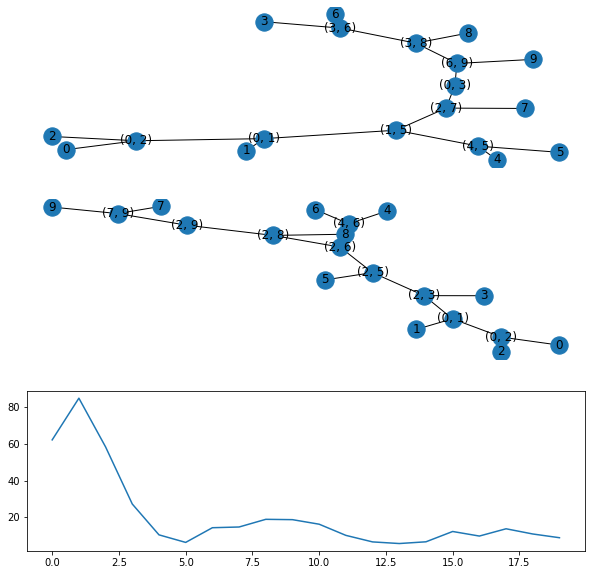

In [216]:
np.random.seed(0)
n_points = 10
pointset = generate_random_points(n_points)
D = generate_distance_metric(pointset)
d1 = generate_random_dists(6, n_points)
d2 = generate_random_dists(5, n_points)
op=train_wasserstein(D, d1, d2, max_iterations=20)